# Ideas for data generation

Create function that describes the integrated MM equation for a particular KM and Vmax

In [2]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np

##########################
### Set up equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                         


##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax



The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

Kcat/KM is: 2000.0


/var/folders/3h/d_p2gtjd78g8c7m6c14chsg00000gq/T/ipykernel_8912/4067342146.py:39: RuntimeWarning: invalid value encountered in log10
  s = -np.log10(fraction_transmittance)


(-0.003, 4.0)

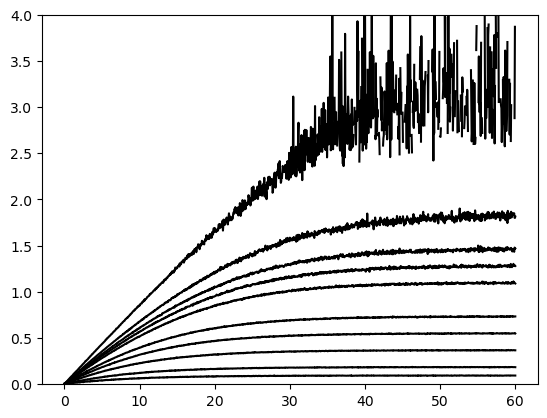

In [29]:
##############################################################################

time_end = 60           ### The end time
n_points = 1200            ### number of points - increase if needed

#########################################
### Create series of time points      ###
#########################################

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)

##########################
### Set up parameters
##########################

E_conc = 1e-9
KM_value = 0.05 / 1000          ### set KM value
kcat_value = 1E2 * 60          ### set kcat value in min^-1
S0_value = .1 / 1000            ### set initial substrate concentration value

print(f"Kcat/KM is: {kcat_value/60/(KM_value*1000):0.1f}")

Vmax_value = E_conc * kcat_value

##########################
### calculate x and y data
##########################
S0_list = np.array([0.005,0.01,0.02,0.03,0.04,0.06,0.07,0.08,0.1,0.2]) / 1000
#S0_list = np.array([0.008]) / 1000

for S0_value in S0_list:
    ### Calculate y according to the function
    s = S0_value - f(t_line, S0_value, KM_value, Vmax_value)   
    ### the Lambert function produces imaginary numbers. Use on the real component
    s = np.real(s) * 18300   
    fraction_transmittance  = 1/(10**s)                              
    fraction_transmittance = np.random.normal(fraction_transmittance, 0.001, len(fraction_transmittance))
    s = -np.log10(fraction_transmittance)
    
    s = np.random.normal(s, 0.001, len(s))
    plt.plot(t_line,s, "k-")



plt.ylim(-.003,4)
#plt.xlim(1,2)
